# Проверка гипотез для увеличения выручки

Я - аналитик крупного интернет-магазина по продаже линеек "Семь раз отмерь". Вместе с коллегами из отдела маркетинга мы подготовили список гипотез для увеличения выручки.

---
В данной работе нам предстоит :
### Приоритизировать 9 гипотез, для этого я:
* Применю фреймворк ICE и RICE, сравню их результаты.

### Запустить А/В тест, для этого я:
* Сделаю вид, что мы его запустили и получили результаты для анализа.

### Провести детальный анализ результатов, для этого я:
* Построю необходимые графики : кумулятивной (с накоплением) выручки по группам, кумулятивного среднего чека по группам, относительного изменения кумулятивного среднего чека группы В к группе А и т.д.
* Посчитаю 95 - 99 перцентили стоимости заказов и количества заказов на пользователя.
* Посчитаю статистические значимости различий : в среднем количестве заказов на посетителя по группам, в среднем чеке заказа по группам.
* Отфильтрую выбросы и пересчитаю статистические значимости различий по скорректированным данным, а также построю графики различий, чтобы увидеть перемены.

### Проанализирую результаты и приму решение об остановке или продолжении теста 

## Открываем и изучаем данные

In [1]:
# в данной ячейке загружаю все необходимые в работе библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
hyp_way = "C://Users//1//Desktop//PROJECTS//A_B TESTS//hypothesis.csv"
orders_way = "C://Users//1//Desktop//PROJECTS//A_B TESTS//orders.csv"
visitors_way = "C://Users//1//Desktop//PROJECTS//A_B TESTS//visitors.csv"
hyp = pd.read_csv(hyp_way, sep=',') #открываем датасет с гипотезами
orders = pd.read_csv(orders_way, sep=',') #открываем датасет с заказами
orders['date'] = orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d')) #переводим столбец в формат datetime64
visitors = pd.read_csv(visitors_way, sep=',') #открываем датасет с посещениями
visitors['date'] = visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d')) #переводим столбец в формат datetime64

In [3]:
for i in hyp, orders, visitors: #перебираем все датасеты
    display(i.head())           #выводим первые 5 строк
    print()
    print(i.info())             #выводим информацию о датасетах
    print()
    print(i.describe())         #выводим информацию о значениях в датасетах (минимум, максимум, среднее, медиана, квартили)
    print()
    print(i.duplicated().sum()) #количество полных дубликатов

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

           Reach     Impact  Confidence    Efforts
count   9.000000   9.000000    9.000000   9.000000
mean    4.777778   4.777778    5.555556   4.888889
std     3.153481   3.192874    3.045944   2.803767
min     1.000000   1.000000    1.000000   1.000000
25%     3.000000   3.000000    3.000000   3.000000
50%     3.000000   3.000000    7.000000   5.000000
75%     8.000000   7.000000    8.000000   6.000000
max    10.000000  10.000000    9.000000  10.000000

0


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None

       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e+09  2.978000e+03
75%     3.237740e+09  3.177606e+09  8.290000e+03
max     4.293856e+09  4.283872e+09  1.294500e+06

0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None

         visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000

0


In [4]:
hyp.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts'] #приводим к нижнему регистру

In [5]:
print('Количество уникальных пользователей в группе А:', orders[orders['group'] == 'A']['visitorId'].nunique())
print('Количество уникальных пользователей в группе В:', orders[orders['group'] == 'B']['visitorId'].nunique())
print('Количество уникальных пользователей в датасете orders:', orders['visitorId'].nunique())
print('Количество пользователей попавших в обе группы:', 
      (orders[orders['group'] == 'A']['visitorId'].nunique()
       + orders[orders['group'] == 'B']['visitorId'].nunique()
       - orders['visitorId'].nunique()) )

Количество уникальных пользователей в группе А: 503
Количество уникальных пользователей в группе В: 586
Количество уникальных пользователей в датасете orders: 1031
Количество пользователей попавших в обе группы: 58


In [6]:
print('Минимальная дата в orders:', orders['date'].min())
print('Максимальная дата в orders:', orders['date'].max())
print('Минимальная дата в visitors:', visitors['date'].min())
print('Максимальная дата в visitors:', visitors['date'].max())

Минимальная дата в orders: 2019-08-01 00:00:00
Максимальная дата в orders: 2019-08-31 00:00:00
Минимальная дата в visitors: 2019-08-01 00:00:00
Максимальная дата в visitors: 2019-08-31 00:00:00


---
Мы вывели данные и немного их предобработали, посмотрим, что получилось :
* Привели даты к нужному формату
* Переименовали столбцы в датафрейме с гипотезами для удобства. В данных orders не буду изменять названия столбцов transactionId и visitorId, в теоретической части это пропускали, и я думаю, здесь это не нужно.
* Пропусков и дубликатов в полученных данных нет
* Интересную ситуацию показал метод describe для датафрейма orders. При средней сумме покупке (столбец revenue) 8348, медиана составляет лишь 2978. Есть явные выбросы, минимальная сумма покупки равна 5, а максимальная 1 294 500. В будущем надо будет отфильтровать данные.
* Размеры групп А и В оказались разными, различие составило 83 юзера! При этом 58 пользователей попали в обе группы. Это плохой знак, в идеальном проведении А/В теста такого быть не должно. 58 пользователей составляет 5,63% от общего количества уникальных пользователей, будем надеяться, что их влияние на результаты будет минимальным. 
* Узнали, что мы имеем данные А/В теста за август 2019 года, при этом диапазон времени в датасетах orders и visitors совпадает. 
---

## Приоритизация гипотез

Воспользуемся методами упорядочивания экспериментов ICE и RICE.

### Метод ICE (impact, confidence, effort/ease)

In [7]:
pd.set_option('display.max_colwidth', None)
display(hyp)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Оценки гипотез проивзедены по 10-бальной шкале.

In [8]:
hyp['ICE'] = round(hyp['impact'] * hyp['confidence'] / hyp['efforts'] , 2)
display(hyp[['hypothesis', 'ICE']].sort_values(by = ['ICE'], ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


---
По методу ICE самыми приоритетными являются гипотезы 8 "Запустить акцию, дающую скидку на товар в день рождения" - 16.2 , 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" - 13.33 и 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - 11.20.

---

### Метод RICE (reach, impact, confidence, effort/ease)

In [9]:
hyp['RICE'] = hyp['reach'] * hyp['impact'] * hyp['confidence'] / hyp['efforts']
display(hyp[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


---
По методу RICE самыми приоритетными являются гипотезы 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - 112.0 , 2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" - 56.0 и 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" - 40.0. При этом гипотеза 7 получила в 2 раза больше баллов относительно следующей наиболее приоритетной гипотезы 2.

---

In [10]:
display(hyp.sort_values(by = 'RICE', ascending=False).head())

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


---
Разберемся почему результаты методов различаются.
Метод ICE и RICE различаются множителем reach, который показывает какой объем пользователей затронет нововведение. Например, компонент reach для гипотезы 8 "Запустить акцию, дающую скидку на товар в день рождения" равен 1, потому что он будет работать только в день рождения пользователей, то есть один день в году для каждого, а это очень мало. Гипотеза 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" коснётся всех пользователей, поэтому reach равен 10.

---
Самой приоритетной будем считать гипотезу №7.

## Запускаем A/B тест

---
Ждём

---

## Анализ A/B теста

In [11]:
#ежедневная посещаемость в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
#суммарная посещаемость в группе А
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]\
                    .agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

#ежедневная посещаемость в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
#суммарная посещаемость в группе В
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
                    .agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
#количество заказов в день в группе А
ordersADaily = (orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
#суммарное количество заказов в день в группе А
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
                    .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

#количество заказов в день в группе В
ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
#суммарное количество заказов в день в группе А
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                    .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1)\
                    .sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
#объединяем все данные в одну таблицу
data = (ordersADaily
    .merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

### График кумулятивной выручки по группам

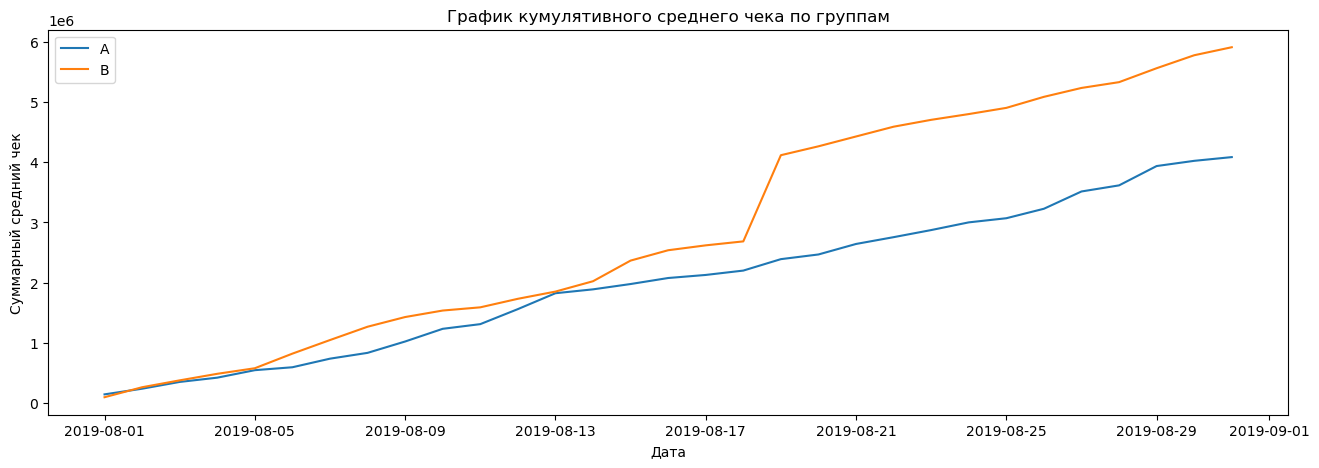

In [12]:
plt.figure(figsize=(16, 5)) #указываем размеры графика

plt.plot(data['date'], data['revenueCummulativeA'], label='A') #cтроим график среднего чека группы А
plt.plot(data['date'], data['revenueCummulativeB'], label='B') #cтроим график среднего чека группы B

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Суммарный средний чек')
plt.xlabel('Дата')
plt.legend(); #показываем легенду графика (график А и В)

---
В самом начале эксперимента группы А и В практически равны по выручке, однако далее группа В постепенно вырывается вперед. Суммарная выручка у группы В сильно выросла 18 - 19 августа, походу в эти дни кто то совершил очень крупную покупку. Проверим эту гипотезу при дальнейшем анализе.

---

### График кумулятивного среднего чека по группам

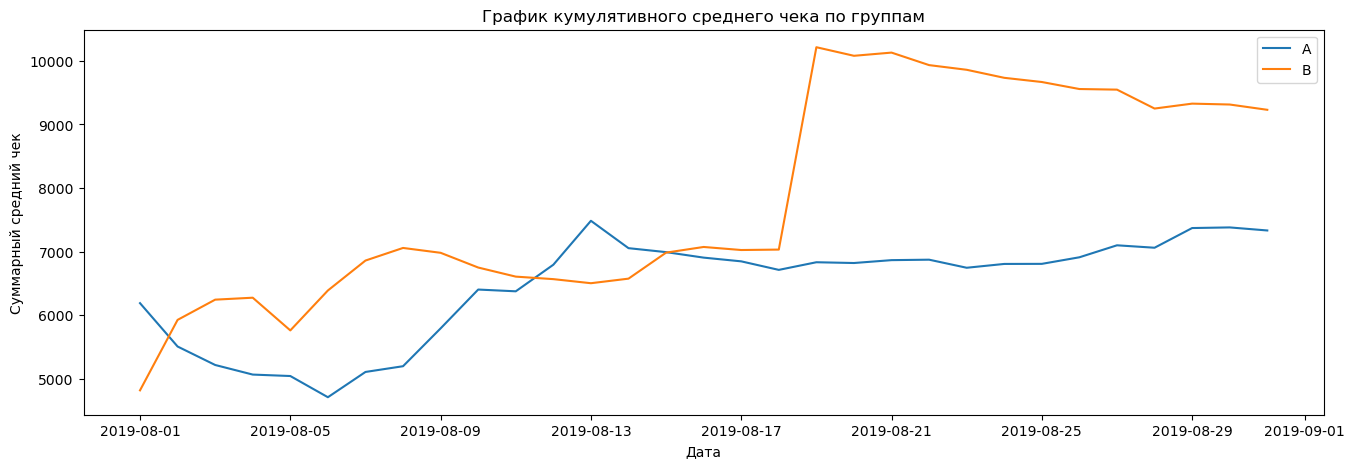

In [13]:
plt.figure(figsize=(16, 5)) #указываем размеры графика

plt.plot(data['date'], data['revenueCummulativeA']/data['ordersCummulativeA'], label='A') #cтроим график среднего чека группы А
plt.plot(data['date'], data['revenueCummulativeB']/data['ordersCummulativeB'], label='B') #cтроим график среднего чека группы B

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Суммарный средний чек')
plt.xlabel('Дата')
plt.legend(); #показываем легенду графика (график А и В)

---
В начале эксперимента видны сильные колебания. С 6 по 13 августа в группе А наблюдаем активный рост среднего чека. В группе В 18-19 августа снова резкий рост среднего чека с дальнейшим постепенным снижением. Всё больше фактов подтверждает наличие крупной покупки. В начале проекта я проверял датасет orders методом describe и максимальное значение в столбце revenue было 1 294 500, вероятно, эта покупка была совершенна именно в 18-19 августа.

---

### График относительного изменения кумулятивного среднего чека группы B к группе A

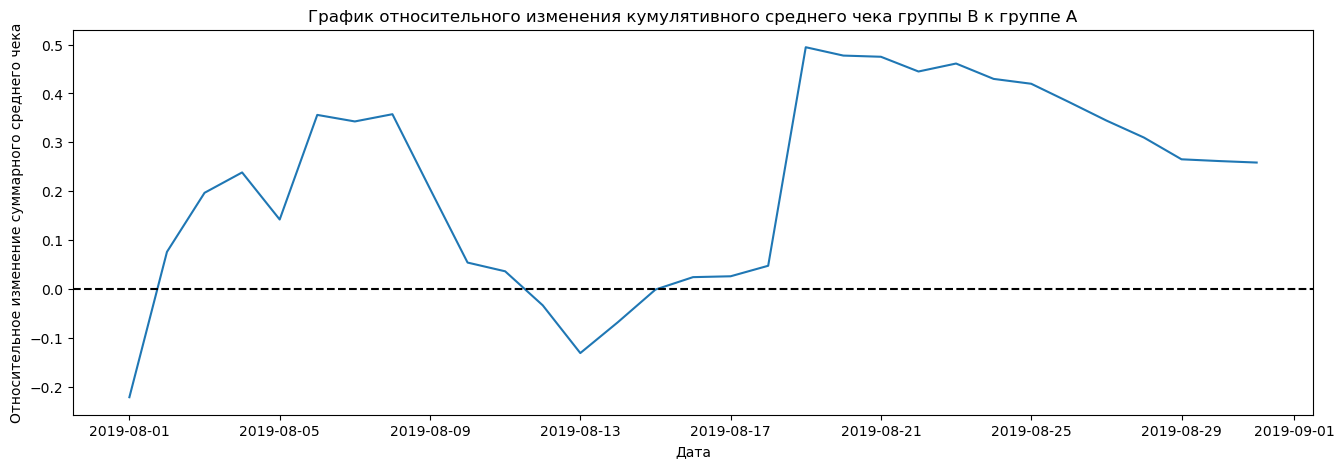

In [14]:
plt.figure(figsize=(16,5)) #указываем размеры графика

# cтроим отношение средних чеков
plt.plot(data['date'], 
         (data['revenueCummulativeB']/data['ordersCummulativeB'])/(data['revenueCummulativeA']/data['ordersCummulativeA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное изменение суммарного среднего чека')
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--'); # добавляем ось X

---
Да, в самом начале A/B теста лидеровала группа А. Затем группа В вырвалась вперед вплоть до 11-12 августа. Крупная покупка усилила превосходство группы В, однако если эту покупку исключить, группа А вырвется в лидеры уже 20-23 августа. 

---

### График кумулятивного среднего количества заказов на посетителя по группам

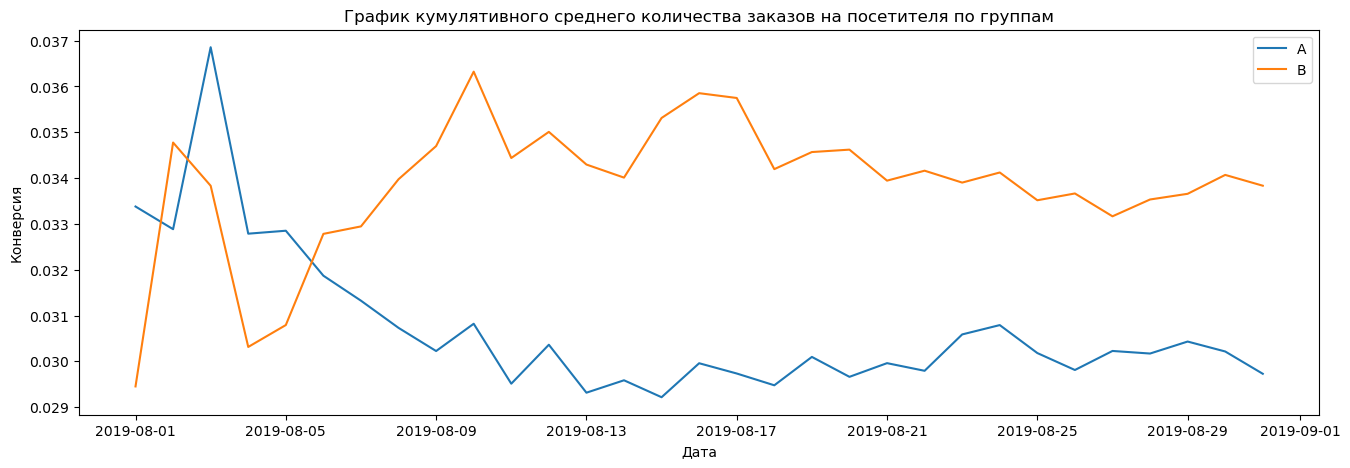

In [15]:
plt.figure(figsize=(16,5)) #указываем размеры графика

plt.plot(data['date'], data['ordersCummulativeA'] / data['visitorsCummulativeA'], label='A')
plt.plot(data['date'], data['ordersCummulativeB'] / data['visitorsCummulativeB'], label='B')

plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.legend(); #показываем легенду графика (график А и В)

---
В первые 1,5 недели теста наблюдаем большие скачки в данных - это нормально. Далее они стабилизируются и можно сделать следующий вывод - среднее количество покупок на пользователя больше в группе В, разница составляет около 10% - 15%. 

---

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

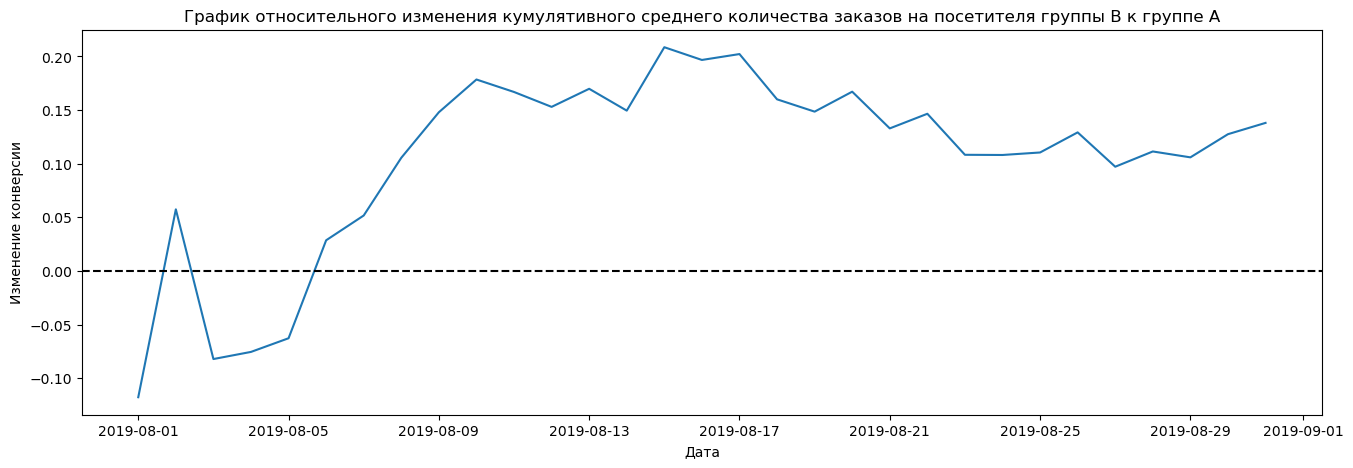

In [16]:
plt.figure(figsize=(16,5)) #указываем размеры графика

plt.plot(data['date'], (data['ordersCummulativeB'] / data['visitorsCummulativeB'])/(data['ordersCummulativeA'] / data['visitorsCummulativeA'])-1)

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel('Изменение конверсии')
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--'); #добавляем ось Х

---
На данному графике хорошо видно преимущество группы В по конверсии пользователей, которое на последних 2 неделях теста действительно равно 10% - 15%.

---

### Точечный график количества заказов по пользователям

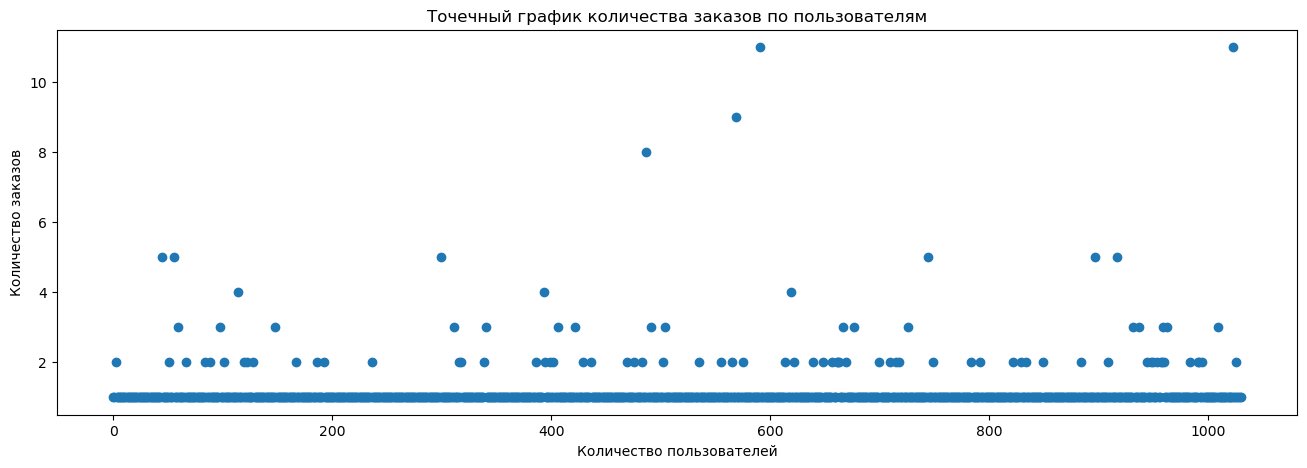

In [17]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['visitorId', 'orders']
 
plt.figure(figsize=(16,5)) #указываем размеры графика
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей');

---
В основном количество заказов у пользователей равно 1, гораздо реже заказывается 2 заказа и совсем редко более 3. Максимальнео число заказов равно 11. Надо просчитать 95 и 99 перцентели, чтобы правильно убрать выбросы. Скорее всего будем убирать из данных количество заказов более 3 - их крайне мало и они портят общую картину.

---

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [18]:
print(np.percentile(ordersByUsers['orders'], [95, 96, 97, 98, 99])) 

[2. 2. 2. 3. 4.]


---
По полученным перцентилям можно сделать вывод, что более 97% делают не более 2 заказов. В 2% пользователей входят те, кто делает 3 и более заказов - их следует убрать из данных.

---

### Точечный график стоимостей заказов

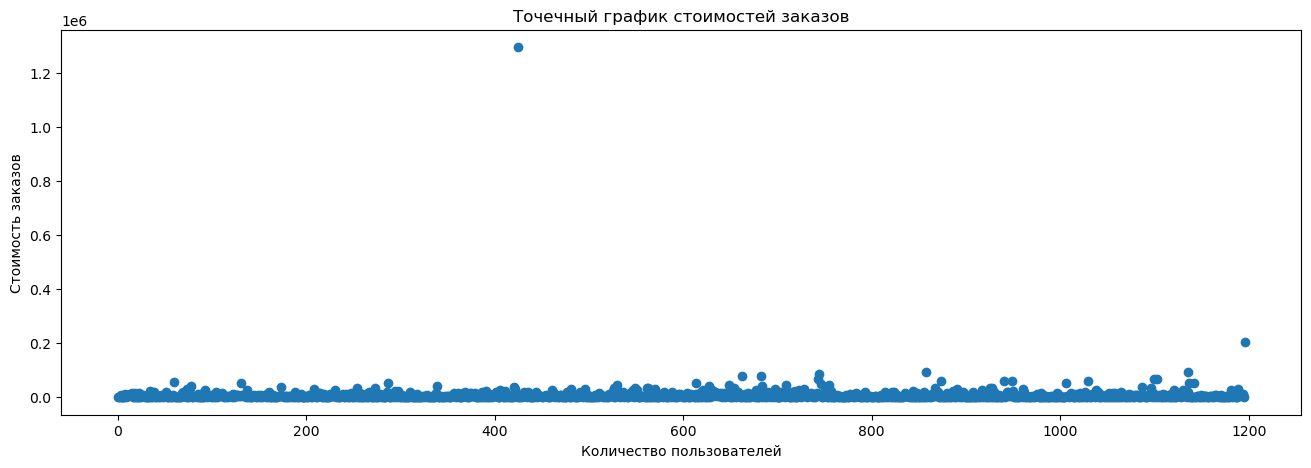

In [19]:
x_values = pd.Series(range(0,len(orders['revenue']))) #задаем границы по оси Х - от нуля до количества строк в датасете orders
plt.figure(figsize=(16,5)) #указываем размеры графика
plt.scatter(x_values, orders['revenue']) #строим точечный график
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей');

---
По полученному графику видим, что основная стоимость заказов менее 100000. График не очень информативен из-за крупного выброса, о котором я писал выше. Для точной оценки посчитаем 95 и 99 перцентили, чтобы в дальнейшем исключить выбросы.

---

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [20]:
print(np.percentile(orders['revenue'], [95, 96, 97, 98, 99])) 

[28000.  31382.  35485.  44133.2 58233.2]


---
Всё стало гораздо понятнее. Более 95% делают заказы стоимостью до 28000 и лишь один процент клиентов заказывают на сумму свыше 58233,2.

---
Предлагаю принять следующие границы для исключения выбросов : количество заказов на пользователя не более 2 включительно (меньше 98 перцентиля), сумма заказа не более 35485 включительно (меньше 97 перцентиля).

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

---
Сформулируем нулевую и альтернативную гипотезы:
* Нулевая гипотеза : Статистически значимых различий в среднем числе заказов пользователей разных групп нет.
* Альтернативная гипотеза : Статистически значимые различия в среднем числе заказов пользователей разных групп есть.

---
Уровень статистической значимости альфа примем равным 5%.

In [21]:
ordersByUsersA = (orders[orders['group'] == 'A']  #считаем количество заказов на каждого пользователя группы А
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (orders[orders['group'] == 'B'] #считаем количество заказов на каждого пользователя группы В
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
ordersByUsersB.columns = ['userId', 'orders']
#создаём выборку, в которой каждый элемент - это число заказов пользователей (или отсутствие заказов, т.е. 0) группы А
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)
#создаём выборку, в которой каждый элемент - это число заказов пользователей (или отсутствие заказов, т.е. 0) группы В
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

print('p-value равно {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Разница между группами {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value равно 0.017
Разница между группами 0.138


---
По сырым данным получаем p-value меньше принятого уровня статистической значимости, значит нулевую гипотезу следует отвергнуть - различия в среднем числе заказов пользователей есть. 
В среднем заказов на посетителя больше в группе В на 13,8 %, чем в группе А.

---

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

---
Сформулируем нулевую и альтернативную гипотезы:
* Нулевая гипотеза : Статистически значимых различий в среднем чеке заказа разных групп нет.
* Альтернативная гипотеза : Статистически значимые различия в среднем чеке заказа разных групп есть.

---
Уровень статистической значимости альфа примем равным 5%.

In [22]:
print('p-value равно {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Разница между группами {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value равно 0.729
Разница между группами 0.259


---
Значение p-value гораздо больше нашего уровня статистической значимости, поэтому нулевую гипотезу отвергнуть нельзя - статистически значимых различий в чеке нет.
Пусть и разница в чеке между группами составила 25,9% в пользу группы В. 

---

### Отфильтруем данные

In [23]:
usersWithManyOrders = pd.concat(
        [ordersByUsersA[ordersByUsersA['orders'] >= np.percentile(ordersByUsers['orders'], 98)]['userId'], #делаем срез пользователей группы А, у которых количество заказов больше 3
        ordersByUsersB[ordersByUsersB['orders'] >= np.percentile(ordersByUsers['orders'], 98)]['userId']], #делаем срез пользователей группы В, у которых количество заказов больше 3
        axis=0)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 97)]['visitorId'] #делаем срез заказов стоимость которых превышает 30000
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)\
    .drop_duplicates()\
    .sort_values()
    
print(abnormalUsers.shape[0]) #смотрим количество срезанных строк

51


---
По исходным данным датасета orders у нас был 1031 уникальный пользователь. 

Мы нашли 51 аномального пользователя, которых следует исключить из нашего исследования, это составляет 4,95%, что меньше разрешенных 5%.

---

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [24]:
# с помощью np.logical_not (логическое "НЕ" - отрицание) мы убираем из данных аномальных пользователей 
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

print('p-value равно {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Разница между группами {0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value равно 0.010
Разница между группами 0.179


---
По "очищенным" данным p-value немного изменился в меньшую сторону : был 1,7%, стал 1%. Разница между группами по количеству заказов составила 17,9% в пользу группы В.

---

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [25]:
print('p-value равно {0:.3f}'.format(
    stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('Разница между группами {0:.3f}'.format(
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
    / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))

p-value равно 0.878
Разница между группами 0.020


---
По "очищенным" данным значение p-value практически не поменялось и стало равным 87,8% - нулевую гипотезу отклонять ни в коем случае нельзя, а вот разница между группами в среднем чеке заказа скорректировалась и стала равной 2% в пользу группы В.

---

In [26]:
ordersMod = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]

ordersADailyMod = (ordersMod[ordersMod['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))
ordersADailyMod.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulativeMod = ordersADailyMod.apply(lambda x: ordersADailyMod[ordersADailyMod['date'] <= x['date']]\
                    .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulativeMod.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDailyMod = (ordersMod[ordersMod['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDailyMod.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulativeMod = ordersBDailyMod.apply(lambda x: ordersBDailyMod[ordersBDailyMod['date'] <= x['date']]
                    .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1)\
                    .sort_values(by=['date'])
ordersBCummulativeMod.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

dataMod = (ordersADailyMod
    .merge(ordersBDailyMod, left_on='date', right_on='date', how='left')
    .merge(ordersACummulativeMod, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulativeMod, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

### График относительного изменения кумулятивного среднего чека группы B к группе A без аномальных пользователей

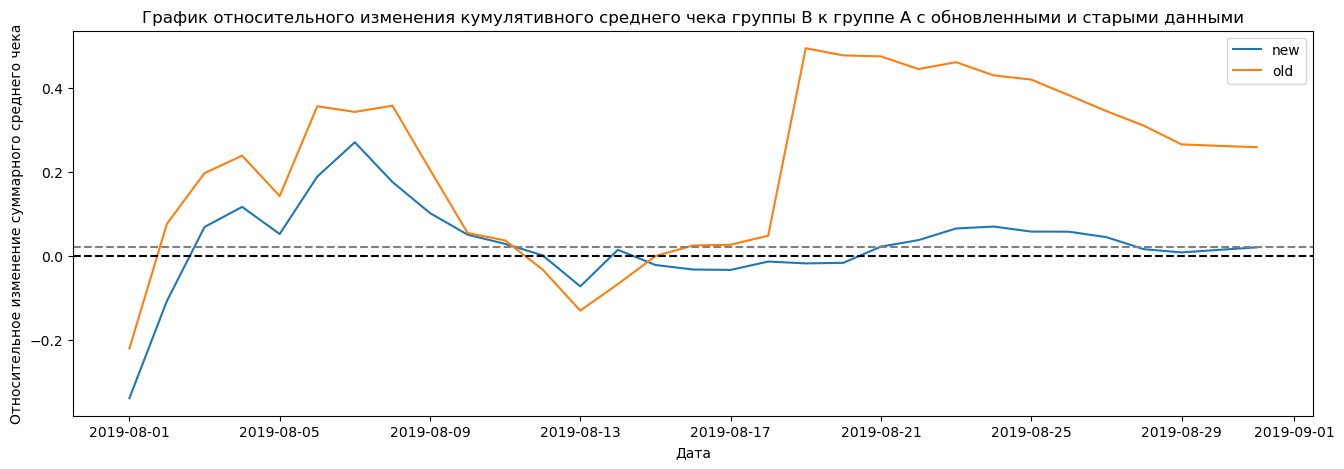

In [27]:
plt.figure(figsize=(16,5)) #указываем размеры графика

# cтроим отношение средних чеков
plt.plot(dataMod['date'], 
         (dataMod['revenueCummulativeB']/dataMod['ordersCummulativeB'])/(dataMod['revenueCummulativeA']/dataMod['ordersCummulativeA'])-1, label='new')
plt.plot(data['date'], 
         (data['revenueCummulativeB']/data['ordersCummulativeB'])/(data['revenueCummulativeA']/data['ordersCummulativeA'])-1, label='old')

plt.axhline(y=0, color='black', linestyle='--') # добавляем ось X
plt.axhline(y=0.02, color='grey', linestyle='--')
plt.legend() #показываем легенду графика (график А и В)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A с обновленными и старыми данными')
plt.ylabel('Относительное изменение суммарного среднего чека')
plt.xlabel('Дата');

---
Исключив аномальных пользователей заметно очень незначительное преимущество группы В - под конец теста прирост составил чуть более 2%. Лидер довольно часто изменялся. Именно такой же результат мы получили при расчете в пункте 4.14.

---

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A без аномальных пользователей

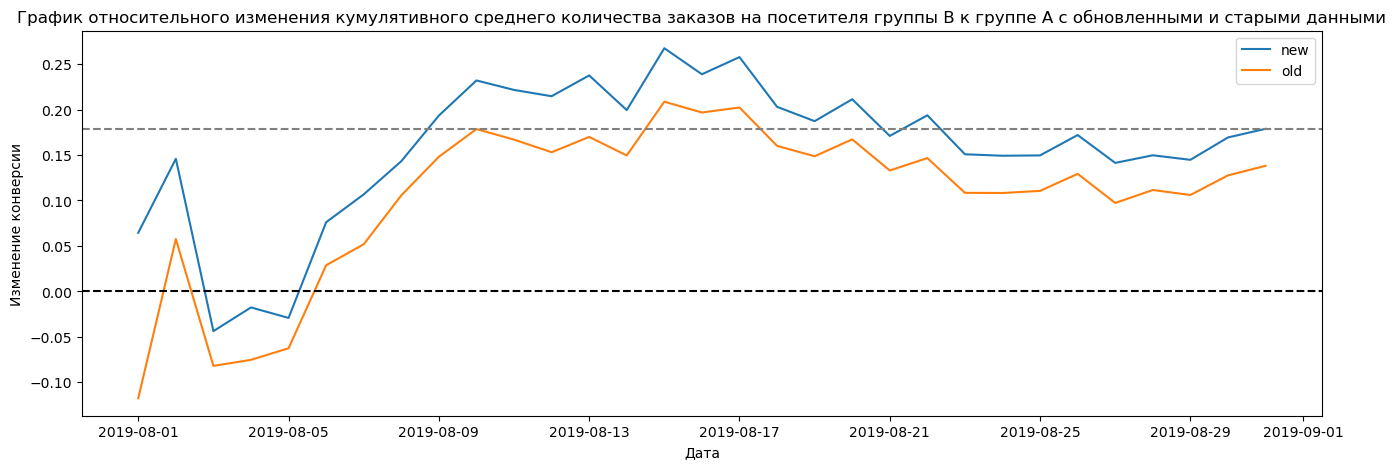

In [28]:
plt.figure(figsize=(16,5)) #указываем размеры графика

plt.plot(dataMod['date'], (dataMod['ordersCummulativeB'] / dataMod['visitorsCummulativeB'])/(dataMod['ordersCummulativeA'] / dataMod['visitorsCummulativeA'])-1, label='new')
plt.plot(dataMod['date'], (data['ordersCummulativeB'] / data['visitorsCummulativeB'])/(data['ordersCummulativeA'] / data['visitorsCummulativeA'])-1, label='old')

plt.axhline(y=0, color='black', linestyle='--') #добавляем ось Х
plt.axhline(y=0.179, color='grey', linestyle='--')
plt.legend() #показываем легенду графика (график А и В)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A с обновленными и старыми данными')
plt.ylabel('Изменение конверсии')
plt.xlabel('Дата');

---
Исключив аномальных пользователей мы увидели, что преимущество группы В в среднем количестве заказов на посетителя только усилилось.

---

### Решение по результатам теста.

Имеющиеся факты:
* Статистически значимые различия в среднем числе заказов пользователей разных групп есть. В среднем заказов на посетителя больше в группе В на 17,9 %, чем в группе А.
* Статистически значимых различий в среднем чеке заказа разных групп нет. Разница между группами в среднем чеке заказа равна 2% в пользу группы В.
* График относительного изменения кумулятивного среднего чека группы B к группе A показал, что практически на всём протяжении теста наблюдается преимущество группы В, при чём к концу теста кривая практически зафиксировалась, нет явных тенденций к росту или падению.
* График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показал явный перевес группы В, нет тенденции к смене лидера.

---
Конечно, различий в среднем чеке мы не обнаружили, однако в группе В стало заметно больше заказов, а это значит, что выручка увеличится.

---
Тест следует остановить и зафиксировать победу группы В.
